# Model Regresji Liniowej: Przewidywanie Cen domów.



## 1. Wstępna inicjalizacja

In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Ustawienie seedu
torch.manual_seed(42)

# Wybranie dostępnego urządzenia
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f'Using device: {DEVICE}')

Using device: cuda


## 2. Przygotowanie zbioru danych i jego obróbka

In [3]:
# Url do danych train i test w formacie raw na github
TRAIN_DATA_URL = 'https://raw.githubusercontent.com/wojgal/Portfolio/refs/heads/main/LinearRegression%20Model/Data/df_train.csv'
TEST_DATA_URL = 'https://raw.githubusercontent.com/wojgal/Portfolio/refs/heads/main/LinearRegression%20Model/Data/df_test.csv'

# Załadowanie danych
train_data = pd.read_csv(TRAIN_DATA_URL)
test_data = pd.read_csv(TEST_DATA_URL)

# Wybranie tylko interesujących nas kolumn i podzielenie danych na X i Y
X_train = train_data['living_in_m2'].values
y_train = train_data['price'].values

X_test = test_data['living_in_m2'].values
y_test = test_data['price'].values

# Przekształcenie danych na tensory i ustawienie ich na korzystanie z DEVICE
X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(dim=1).to(DEVICE)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(dim=1).to(DEVICE)

X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(dim=1).to(DEVICE)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(dim=1).to(DEVICE)

## 3. Stworzenie funkcji do wizualizacji danych i postępów

In [4]:
# Funkcja do wizualizacji danych i predykcji modeli
def plot_predictions(X_test, y_test, y_preds=None):
  plt.figure(figsize=(10, 7))
  plt.scatter(X_test, y_test, c='b', s=4, label='Testing Data')

  if y_preds is not None:
    plt.scatter(X_test, y_preds, c='g', s=4, label='Model Predictions')

  plt.legend(prop={'size': 14})

In [5]:
# Funkcja do wizauliazcji funkcji straty
def plot_loss(epochs, train_loss, test_loss):
  plt.figure(figsize=(10, 7))
  plt.plot(epochs, train_loss, label='Train loss')
  plt.plot(epochs, test_loss, label='Test loss')
  plt.title('Train and test loss values')
  plt.ylabel('Loss')
  plt.xlabel('Epochs')
  plt.legend()


## 4. Zbudowanie klasy modelu regresji liniowej

In [6]:
# Stworzenie klasy naszego modelu regresji liniowej
class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()

    self.linear_layer = nn.Linear(in_features=1, out_features=1, device=DEVICE)

  def forward(self, X: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(X)

# Stworzenie obiektu modelu
model = LinearRegressionModel()


## 5. Predykcje wyników modelu przed treningiem

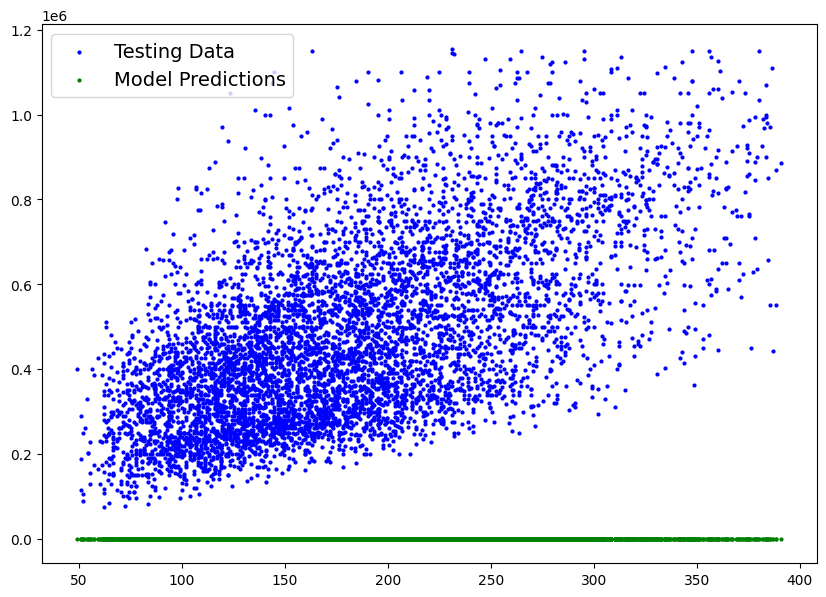

In [7]:
# Predykcje modelu przed treningiem i ich wizualizacja
model.eval()
with torch.inference_mode():
  y_preds_before_training = model(X_test)

plot_predictions(X_test.cpu(), y_test.cpu(), y_preds_before_training.cpu())

## 6. Pętla treningowa

In [8]:
# Ustalenie szybkości uczenia się (Learning Rate)
LR = 0.05

# Stworzenie funkcji straty i optymalizatora
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=LR)

In [9]:
# Inicjalizacja potrzebnych zmiennych
EPOCHS = 501
MODULO = EPOCHS // 5
epochs_count = []
train_loss_values = []
test_loss_values = []

# Pętla treningowa
for epoch in range(EPOCHS):
  # Trenowanie modelu
  model.train()

  y_preds = model(X_train)
  loss = loss_fn(y_preds, y_train)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Testowanie modelu
  model.eval()

  with torch.inference_mode():
    test_preds = model(X_test)

    test_loss = loss_fn(test_preds, y_test)

  # Przedstawienie stanu modelu, co daną ilość epok
  if epoch % MODULO == 0:
    epochs_count.append(epoch)
    train_loss_values.append(loss.detach().cpu())
    test_loss_values.append(test_loss.cpu())

    print(f'Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}\n')



Epoch: 0 | Loss: 475244.0625 | Test loss: 473721.5

Epoch: 100 | Loss: 310080.90625 | Test loss: 308842.25

Epoch: 200 | Loss: 180919.125 | Test loss: 180775.890625

Epoch: 300 | Loss: 144793.671875 | Test loss: 145384.1875

Epoch: 400 | Loss: 136756.515625 | Test loss: 137535.953125

Epoch: 500 | Loss: 135002.15625 | Test loss: 135773.15625



## 7. Predykcje modelu po treningu

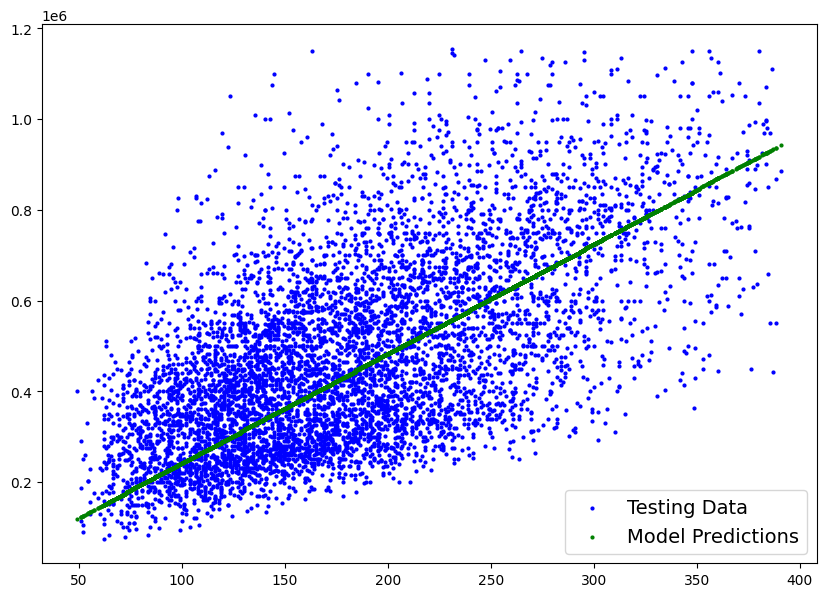

In [10]:
# Predykcje modelu po treningu i ich wizualizacja
model.eval()

with torch.inference_mode():
  y_preds_after_train = model(X_test)

plot_predictions(X_test.cpu(), y_test.cpu(), y_preds_after_train.cpu())

## 8. Wizualizacja funkcji straty dla train i loss

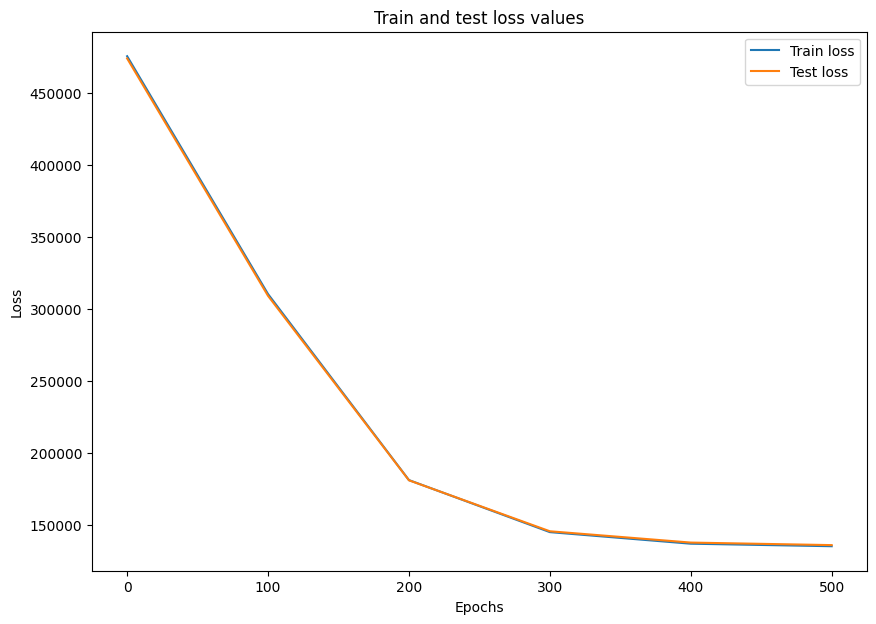

In [11]:
# Przedstawienie wykresu funkcji straty dla train i test
plot_loss(epochs_count, train_loss_values, test_loss_values)

## 9. Zapisanie modelu do pliku

In [12]:
# Zapisanie modelu
MODEL_NAME = 'model.pth'
torch.save(obj=model.state_dict(), f=MODEL_NAME)